In [242]:
# Importing the required libraries

import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import re
import random
# import yfinance as yf
%matplotlib inline

In [243]:
# change defaults to be less ugly
mpl.rc('xtick', labelsize=14, color="#222222") 
mpl.rc('ytick', labelsize=14, color="#222222") 
mpl.rc('font', **{'family':'sans-serif','sans-serif':['Arial']})
mpl.rc('font', size=16)
mpl.rc('xtick.major', size=6, width=1)
mpl.rc('xtick.minor', size=3, width=1)
mpl.rc('ytick.major', size=6, width=1)
mpl.rc('ytick.minor', size=3, width=1)
mpl.rc('axes', linewidth=1, edgecolor="#222222", labelcolor="#222222")
mpl.rc('text', usetex=False, color="#222222")

In [244]:
guessed_sectors = {
    'AAT': 'Real Estate',
    'ABCB': 'Financials',
    'ACIW': 'Information Technology',
    'AHR': 'Real Estate',
    'AKR': 'Real Estate',
    'AMAL': 'Financials',
    'APLS': 'Health Care',
    'ATGE': 'Education',
    'ATO': 'Utilities',
    'AUB': 'Financials',
    'AVPT': 'Information Technology',
    'BANF': 'Financials',
    'BANR': 'Financials',
    'BBSI': 'Industrials',
    'BERY': 'Materials',
    'BHLB': 'Financials',
    'BK': 'Financials',
    'BKU': 'Financials',
    'BKV': 'Energy',
    'BNL': 'Real Estate',
    'BOKF': 'Financials',
    'BRK-B': 'Financials',
    'BRO': 'Financials',
    'BRX': 'Real Estate',
    'BY': 'Financials',
    'CASH': 'Financials',
    'CATY': 'Financials',
    'CBRE': 'Real Estate',
    'CBSH': 'Financials',
    'CBU': 'Financials',
    'CDP': 'Real Estate',
    'CE': 'Materials',
    'CET': 'Financials',
    'CFG': 'Financials',
    'CHCO': 'Financials',
    'CHRD': 'Energy',
    'CMPO': 'Consumer Discretionary',
    'CNO': 'Financials',
    'CNOB': 'Financials',
    'CNS': 'Financials',
    'COLB': 'Financials',
    'COOP': 'Financials',
    'CORT': 'Health Care',
    'COUR': 'Information Technology',
    'CPK': 'Utilities',
    'CRS': 'Materials',
    'CRVL': 'Industrials',
    'CSWI': 'Industrials',
    'CTBI': 'Financials',
    'CVCO': 'Consumer Discretionary',
    'CVLT': 'Information Technology',
    'CVNA': 'Consumer Discretionary',
    'CW': 'Industrials',
    'CWK': 'Real Estate',
    'DCOM': 'Financials',
    'DGX': 'Health Care',
    'DK': 'Energy',
    'DRS': 'Industrials',
    'DV': 'Information Technology',
    'EAT': 'Consumer Discretionary',
    'EBC': 'Financials',
    'EFSC': 'Financials',
    'ENVA': 'Financials',
    'EPRT': 'Real Estate',
    'ESE': 'Industrials',
    'EVR': 'Financials',
    'EVRG': 'Utilities',
    'EYE': 'Health Care',
}


In [304]:
# Load the correlation data and keep required columns
df = pd.read_csv("filtered_correlations_095.csv")
df = df[['Id', 'Source_Ticker', 'Target_Ticker', 'Weight']]

# Load sector sources
sector_df1 = pd.read_csv("filled_sector_data_yfinance.csv")
sector_df2 = pd.read_csv("additional_data.csv")

# Cleaning function to standardize tickers (remove non-alphanumeric characters)
def clean_ticker(ticker):
    return re.sub(r'[^A-Za-z0-9]', '', str(ticker)).upper()

# Apply cleaning to each source
sector_df1['Clean_Symbol'] = sector_df1['Symbol'].apply(clean_ticker)
sector_df2['Clean_Symbol'] = sector_df2['Symbol'].apply(clean_ticker)

# Create sector lookup maps
sector_map_1 = dict(zip(sector_df1['Clean_Symbol'], sector_df1['Sector']))
sector_map_2 = dict(zip(sector_df2['Clean_Symbol'], sector_df2['Sector']))
guessed_map = {clean_ticker(k): v for k, v in guessed_sectors.items()}

# Combine maps: priority is guessed > sector_df1 > sector_df2
sector_map = sector_map_2.copy()
sector_map.update(sector_map_1)
sector_map.update(guessed_map)

# Clean tickers in df
df['Clean_Source_Ticker'] = df['Source_Ticker'].apply(clean_ticker)
df['Clean_Target_Ticker'] = df['Target_Ticker'].apply(clean_ticker)

# Map sector info
df['Source_Sector'] = df['Clean_Source_Ticker'].map(sector_map)
df['Target_Sector'] = df['Clean_Target_Ticker'].map(sector_map)

# Define a remapping for similar sectors
sector_group_map = {
    'Financials': 'Financial Services',
    'Finance': 'Financial Services',
    'Financial Services': 'Financial Services',
    'Health Care': 'Healthcare',
    'Healthcare': 'Healthcare'
}

# Apply the remapping to Source_Sector and Target_Sector
df['Source_Sector'] = df['Source_Sector'].replace(sector_group_map)
df['Target_Sector'] = df['Target_Sector'].replace(sector_group_map)

# Identify missing sectors
missing_df = df[df['Source_Sector'].isna() | df['Target_Sector'].isna()]
missing_cleaned = sorted(set(missing_df['Clean_Source_Ticker'].tolist() + missing_df['Clean_Target_Ticker'].tolist()))
print("Sectors found: " + str((1 - (len(missing_cleaned)/len(sector_map)))*100) +"%")




Sectors found: 96.90631808278867%


In [246]:
# Create an undirected graph from the correlation data


G_stocks = nx.Graph()

# Add edges based on correlation weights
for _, row in df.iterrows():
    source = row['Source_Ticker']
    target = row['Target_Ticker']
    weight = row['Weight']
    G_stocks.add_edge(source, target, weight=weight)

# Add sector as a node attribute
for _, row in df.iterrows():
    source = row['Source_Ticker']
    target = row['Target_Ticker']
    source_sector = row['Source_Sector']
    target_sector = row['Target_Sector']
    
    if source not in G_stocks.nodes:
        G_stocks.add_node(source)
    if target not in G_stocks.nodes:
        G_stocks.add_node(target)
    
    G_stocks.nodes[source]['sector'] = source_sector
    G_stocks.nodes[target]['sector'] = target_sector

# Show basic graph statistics
num_nodes = G_stocks.number_of_nodes()
num_edges = G_stocks.number_of_edges()
sample_edges = list(G_stocks.edges(data=True))[:5]

(num_nodes, num_edges, sample_edges)
sample_nodes = [(node, G_stocks.nodes[node]) for node in list(G_stocks.nodes)[:10]]
sample_nodes

[('BRK-B', {'sector': 'Financial Services'}),
 ('PGR', {'sector': 'Financial Services'}),
 ('WELL', {'sector': 'Real Estate'}),
 ('WEC', {'sector': 'Utilities'}),
 ('BRO', {'sector': 'Financial Services'}),
 ('PPL', {'sector': 'Utilities'}),
 ('ATO', {'sector': 'Utilities'}),
 ('LNT', {'sector': 'Utilities'}),
 ('EVRG', {'sector': 'Utilities'}),
 ('ORI', {'sector': 'Financial Services'})]

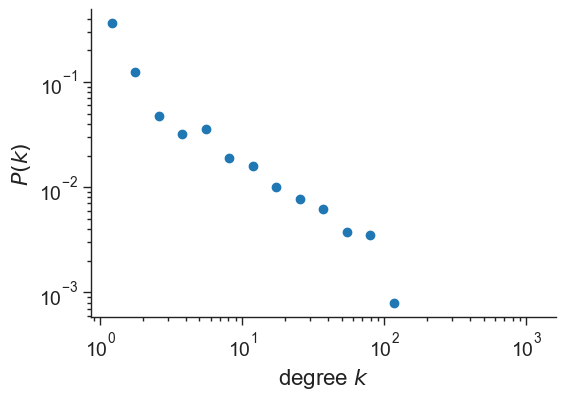

In [247]:
# Function Defintions

# Function to plot a degree distribution graph (P(k) vs k graph)
def plot_degree_dist(G):
    
    degrees = [G.degree(n) for n in G.nodes()]
    kmin = min(degrees)
    kmax = max(degrees)
    
    if kmin>0:
        bin_edges = np.logspace(np.log10(kmin), np.log10(kmax)+1, num=20)
    else:
        bin_edges = np.logspace(0, np.log10(kmax)+1, num=20)
    density, _ = np.histogram(degrees, bins=bin_edges, density=True)

    fig = plt.figure(figsize=(6,4))

    log_be = np.log10(bin_edges)
    x = 10**((log_be[1:] + log_be[:-1])/2)
    plt.loglog(x, density, marker='o', linestyle='none')
    plt.xlabel(r"degree $k$", fontsize=16)
    plt.ylabel(r"$P(k)$", fontsize=16)

    ax = plt.gca()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')

plot_degree_dist(G_stocks)

1. Degree Centrality
How many direct connections a stock has (i.e. how many other stocks it’s strongly correlated with).
High degree → stock is correlated with many others.

Useful to find "hubs" in the market — big influencers.

2. Clustering Coefficient
How connected a stock’s neighbors are to each other.
High clustering → stock is part of a tight-knit group, where its correlated stocks are also correlated with each other.

Helps find tight local communities (e.g. energy sector stocks all tightly correlated).

3. Assortativity (by degree)
Do highly-connected stocks tend to connect to other highly-connected ones (positive assortativity)?
Or do popular stocks link more to niche ones (negative assortativity)?

Positive assortativity → big players link with big players. Maybe blue-chip stocks correlate together.
Negative assortativity → hubs link to many less-connected stocks (like ETFs or indices to individual names).

Degree - Who’s most connected
Clustering Coefficient - Are neighbors forming “families”?
Assortativity - Are popular stocks linking with other popular ones?


"We used three key network metrics to understand how stocks relate:
Degree centrality showed us which stocks are most widely connected to others.
Clustering coefficient revealed whether groups of stocks form tightly connected sectors.
Assortativity helped us understand if large players link with other large players or diversify their connections."

Bonus Suggestion (if time permits)
Community detection (like Louvain algorithm) to group stocks into “clusters” based on connection density.
e.g.: We found 6 major groups of stocks that move together — possibly corresponding to sectors.

In [248]:
# using 1) clustering coefficient (connectness), 2) degree ceentrality (no. of connections) 3) Assortativity 
# Maybe 1) Eigenvector centrality, for market leaders 2) Communities (Louvain method and label propagation)  
cluster_coefficent_mean_real = np.mean(list(nx.clustering(G_stocks).values()))
cluster_coefficent_stock_real = nx.clustering(G_stocks)
# Calculate degree centrality
degree_centrality_real = nx.degree_centrality(G_stocks)

# Calculate assortativity coefficient based on the 'sector' attribute
assortativity_by_sector_real = nx.attribute_assortativity_coefficient(G_stocks, 'sector')
eigen_centrality_real = nx.eigenvector_centrality(G_stocks)

# Display top degree centrality values and the assortativity coefficient
# top_central_nodes = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)[:10]

print("assortativity_by_sector " ,assortativity_by_sector_real)
print("Average Clustering Coefficient: ", cluster_coefficent_mean_real)


assortativity_by_sector  0.2049064381763258
Average Clustering Coefficient:  0.45761541828288516


In [299]:
# Calculate the number of connected components
num_components = nx.number_connected_components(G_stocks)
print("Number of connected components:", num_components)

# Calculate average path length
if nx.is_connected(G_stocks):
    avg_path_length = nx.average_shortest_path_length(G_stocks)
    print("Average path length (connected graph):", avg_path_length)
else:
    # Graph is not connected: compute for each connected component
    components = [G_stocks.subgraph(c).copy() for c in nx.connected_components(G_stocks)]
    
    # Compute weighted average of average path lengths
    total_nodes = sum(len(comp.nodes()) for comp in components)
    weighted_avg = sum(nx.average_shortest_path_length(comp) * len(comp.nodes()) for comp in components) / total_nodes
    print("Average path length (weighted over connected components):", weighted_avg)
    
    # Optionally, print the average for each component:
    for i, comp in enumerate(components):
        apl = nx.average_shortest_path_length(comp)
        print(f"Component {i+1} (nodes: {len(comp.nodes())}): avg path length = {apl}")

Number of connected components: 19
Average path length (weighted over connected components): 3.276323079298475
Component 1 (nodes: 643): avg path length = 3.4166266963173983
Component 2 (nodes: 2): avg path length = 1.0
Component 3 (nodes: 2): avg path length = 1.0
Component 4 (nodes: 3): avg path length = 1.3333333333333333
Component 5 (nodes: 2): avg path length = 1.0
Component 6 (nodes: 2): avg path length = 1.0
Component 7 (nodes: 2): avg path length = 1.0
Component 8 (nodes: 3): avg path length = 1.3333333333333333
Component 9 (nodes: 4): avg path length = 1.5
Component 10 (nodes: 2): avg path length = 1.0
Component 11 (nodes: 4): avg path length = 1.6666666666666667
Component 12 (nodes: 2): avg path length = 1.0
Component 13 (nodes: 2): avg path length = 1.0
Component 14 (nodes: 2): avg path length = 1.0
Component 15 (nodes: 3): avg path length = 1.3333333333333333
Component 16 (nodes: 2): avg path length = 1.0
Component 17 (nodes: 2): avg path length = 1.0
Component 18 (nodes: 2

In [249]:
# Convert degree centrality dictionary into a DataFrame
deg_centrality_df = pd.DataFrame.from_dict(degree_centrality_real, orient='index', columns=['Degree_Centrality'])
deg_centrality_df.index.name = 'Ticker'

cluster_df = pd.DataFrame.from_dict(cluster_coefficent_stock_real, orient='index', columns=['Cluster_coefficient'])
cluster_df.index.name = 'Ticker'

eigen_centrality_df = pd.DataFrame.from_dict(eigen_centrality_real, orient='index', columns=['Eigenvector_Centrality'])
eigen_centrality_df.index.name = 'Ticker'


In [250]:
# Count frequency of each unique sector from both Source and Target columns combined
sector_counts = pd.concat([df['Source_Sector'], df['Target_Sector']]).value_counts()
sector_percentages = (sector_counts / sector_counts.sum()).sort_values(ascending=False)

sector_percentages
# sector_counts




Financial Services        0.541339
Industrials               0.072695
Real Estate               0.064944
Technology                0.059483
Utilities                 0.055255
Energy                    0.051145
Consumer Cyclical         0.040399
Healthcare                0.033823
Consumer Defensive        0.029712
Communication Services    0.020963
Information Technology    0.010863
Consumer Discretionary    0.008925
Materials                 0.006459
Basic Materials           0.002936
Education                 0.001057
Name: count, dtype: float64

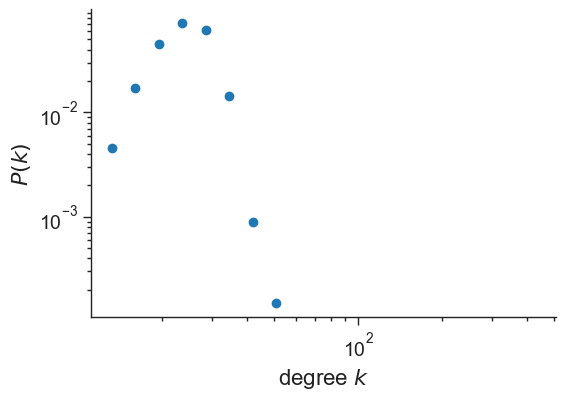

In [251]:
GN = len(G_stocks.nodes()) # G.number_of_nodes()
max_L = GN*(GN-1)/2
actual_L = len(G_stocks.edges())
p = actual_L/max_L

ER = nx.erdos_renyi_graph(GN, p, directed=False)

plot_degree_dist(ER)

In [252]:
# assigned sectors completely randomly
clustering_ER = []
assortativity_ER = []
degree_centrality_er_list = []
clustering_er_list = []
eigen_er_list = []
sectors = list(sector_percentages.keys())
probabilities = [1/len(sectors)]*len(sectors)


for i in range(1000): # 1000 is better
    
    ER = nx.erdos_renyi_graph(GN, p, directed=False)
    # Step 2: Create a mapping from ER node index to actual tickers
    tickers = list(G_stocks.nodes)
    mapping = dict(zip(ER.nodes, tickers))

    # Step 3: Relabel ER graph nodes using this mapping
    ER = nx.relabel_nodes(ER, mapping)

        # Randomly assign a sector to each node
    random_sector_assignments = random.choices(sectors, weights=probabilities, k=ER.number_of_nodes())
    for node, sector in zip(ER.nodes, random_sector_assignments):
        ER.nodes[node]['sector'] = sector

    clustering_ER.append(np.mean(list(nx.clustering(ER).values())))
    assortativity_ER.append(nx.attribute_assortativity_coefficient(ER, 'sector'))
    degree_centrality_er_list.append(nx.degree_centrality(ER))
    clustering_er_list.append(nx.clustering(ER))
    eigen_er_list.append(nx.eigenvector_centrality(ER))
    

# Convert lists to DataFrames indexed by ticker
deg_centrality_er_df = pd.DataFrame(degree_centrality_er_list).T  
deg_centrality_er_df.index.name = 'Ticker'

clustering_er_df = pd.DataFrame(clustering_er_list).T
clustering_er_df.index.name = 'Ticker'

eigen_er_df = pd.DataFrame(eigen_er_list).T
eigen_er_df.index.name = 'Ticker'

# Compute mean and std per node
deg_centrality_er_stats = pd.DataFrame({
    "ER_Degree_Mean": deg_centrality_er_df.mean(axis=1),
    "ER_Degree_Std": deg_centrality_er_df.std(axis=1)
})

clustering_er_stats = pd.DataFrame({
    "ER_Cluster_Mean": clustering_er_df.mean(axis=1),
    "ER_Cluster_Std": clustering_er_df.std(axis=1)
})

eigen_er_stats = pd.DataFrame({
    "ER_eigen_Mean": eigen_er_df.mean(axis=1),
    "ER_eigen_Std": eigen_er_df.std(axis=1)
})



print(np.mean(clustering_ER))
print(np.std(clustering_ER))

print(np.mean(assortativity_ER))
print(np.std(assortativity_ER))


0.036732318051310775
0.0008415377735087937
-0.0013411673461568656
0.0027813976286190237


In [253]:
# Merge with real graph metrics
deg_centrality_df = deg_centrality_df.join(deg_centrality_er_stats, how='left')
cluster_df = cluster_df.join(clustering_er_stats, how='left')
eigen_centrality_df = eigen_centrality_df.join(eigen_er_stats, how='left')

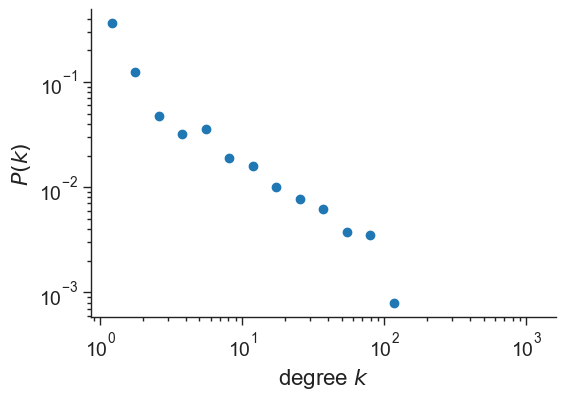

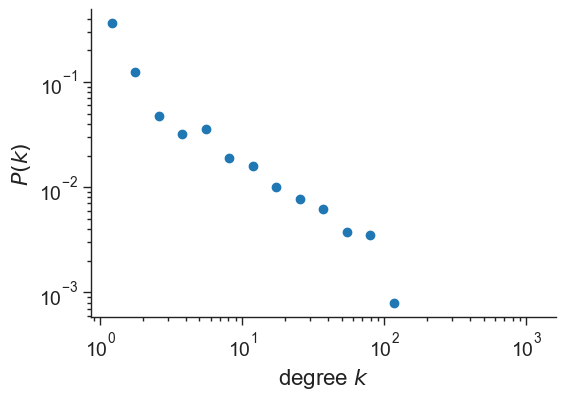

In [254]:
# Calculating metrics for a Degree Preservation Graph, checking the degree distribution

DP = G_stocks.copy() # the function edits the graph in place

nx.double_edge_swap(DP,nswap=10*G_stocks.number_of_edges(),max_tries=1000000)
plot_degree_dist(DP)
plot_degree_dist(G_stocks)

2 ways to assign sectors
1) Each node has sector percentage to be a sector so we have the same amount of noeds (Picking this for now)
2) The node will be the exact sector

In [255]:
# Let's create the ensemble.
# assigned sectors based on percentage in the real graph

# clustering_DP = []
# short_path_DP = []

# for i in range(100): # 1000 is better
#     DP = G_stocks.copy()
#     nx.double_edge_swap(DP,nswap=10*G_stocks.number_of_edges(),max_tries=1000000)
#     C_DP = np.mean(list(nx.clustering(DP).values()))
#     # if nx.is_connected(DP)==True:
#     #     d_DP = nx.average_shortest_path_length(DP,weight=None)
#     clustering_DP.append(C_DP)
#     # short_path_DP.append(d_DP)
    
# print(np.mean(clustering_DP))
# print(np.std(clustering_DP))


# assigned sectors completely randomly
clustering_DP = []
assortativity_DP = [] # approach 1
assortativity_DP_exact = [] # approach 2
degree_centrality_dp_list = []
clustering_dp_list = []
eigen_dp_list = []
sectors = list(sector_percentages.keys())
probabilities = [float(sector_percentages[sector]) for sector in sectors]

# 1. Create a mapping from original graph node to sector
sector_map = nx.get_node_attributes(G_stocks, 'sector')



for i in range(1000): # 1000 is better

    DP = G_stocks.copy()
    nx.double_edge_swap(DP,nswap=10*G_stocks.number_of_edges(),max_tries=1000000)
    
    # Step 2: Create a mapping from node index to actual tickers
    tickers = list(G_stocks.nodes)
    mapping = dict(zip(DP.nodes, tickers))

    # Step 3: Relabel graph nodes using this mapping
    DP = nx.relabel_nodes(DP, mapping)

    # 2. Assign same sectors to the new graph (ER, config, etc.)
    for node in DP.nodes:
        DP.nodes[node]['sector'] = sector_map.get(node, None)  # Fallback to None if missing
    assortativity_DP_exact.append(nx.attribute_assortativity_coefficient(DP, 'sector'))

    # Assign sectors to each node
    random_sector_assignments = random.choices(sectors, weights=probabilities, k=DP.number_of_nodes())
    for node, sector in zip(DP.nodes, random_sector_assignments):
        DP.nodes[node]['sector'] = sector

    clustering_DP.append(np.mean(list(nx.clustering(DP).values())))
    assortativity_DP.append(nx.attribute_assortativity_coefficient(DP, 'sector'))
    degree_centrality_dp_list.append(nx.degree_centrality(DP))
    clustering_dp_list.append(nx.clustering(DP))
    eigen_dp_list.append(nx.eigenvector_centrality(DP))

# Convert lists to DataFrames indexed by ticker
deg_centrality_dp_df = pd.DataFrame(degree_centrality_dp_list).T  
deg_centrality_dp_df.index.name = 'Ticker'

clustering_dp_df = pd.DataFrame(clustering_dp_list).T
clustering_dp_df.index.name = 'Ticker'

eigen_dp_df = pd.DataFrame(eigen_dp_list).T
eigen_dp_df.index.name = 'Ticker'

# Compute mean and std per node
deg_centrality_dp_stats = pd.DataFrame({
    "DP_Degree_Mean": deg_centrality_dp_df.mean(axis=1),
    "DP_Degree_Std": deg_centrality_dp_df.std(axis=1)
})

clustering_dp_stats = pd.DataFrame({
    "DP_Cluster_Mean": clustering_dp_df.mean(axis=1),
    "DP_Cluster_Std": clustering_dp_df.std(axis=1)
})

eigen_dp_stats = pd.DataFrame({
    "DP_Eigen_Mean": eigen_dp_df.mean(axis=1),
    "DP_Eigen_Std": eigen_dp_df.std(axis=1)
})


print(np.mean(clustering_DP))
print(np.std(clustering_DP))

print(np.mean(assortativity_DP))
print(np.std(assortativity_DP))

print(np.mean(assortativity_DP_exact))
print(np.std(assortativity_DP_exact))




0.18801918231401368
0.005717127775469383
-0.0038254139123588145
0.0044909392635226345
-0.009121650450818973
0.004171116318258099


In [ ]:
# Merge with real graph metrics
deg_centrality_df = deg_centrality_df.join(deg_centrality_dp_stats, how='left')
cluster_df = cluster_df.join(clustering_dp_stats, how='left')
eigen_centrality_df = eigen_centrality_df.join(eigen_dp_stats, how='left')

In [259]:
deg_centrality_df

,Degree_Centrality,ER_Degree_Mean,ER_Degree_Std,DP_Degree_Mean,DP_Degree_Std
Ticker,,,,,
BRK-B,0.014599,0.036762,0.007094,0.014599,3.471183e-18
PGR,0.010219,0.036404,0.007213,0.010219,3.471183e-18
WELL,0.056934,0.037050,0.007174,0.056934,0.000000e+00
WEC,0.035036,0.037292,0.007278,0.035036,1.388473e-17
BRO,0.039416,0.036746,0.007092,0.039416,6.942366e-18
...,...,...,...,...,...
INSW,0.001460,0.036822,0.007127,0.001460,0.000000e+00
LPG,0.001460,0.036657,0.007369,0.001460,0.000000e+00
ALEX,0.002920,0.036425,0.007079,0.002920,0.000000e+00


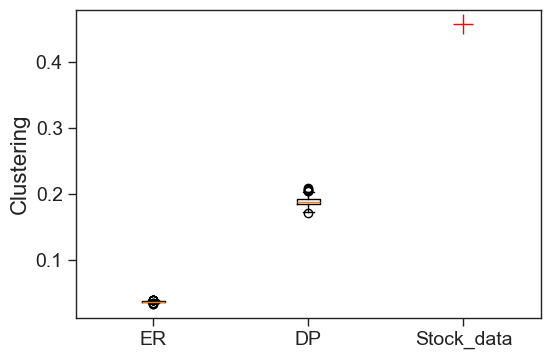

In [260]:
# Clustering coefficient
fig = plt.figure(figsize=(6,4))

plt.boxplot([clustering_ER,clustering_DP], positions=[1,2])
plt.plot(3,cluster_coefficent_mean_real,'r',marker='+',markersize=15)
ax = plt.gca()
ax.set_xticks([1,2,3],labels=['ER','DP','Stock_data'])
plt.ylabel('Clustering')
plt.xlim([0.5,3.5])
plt.show()

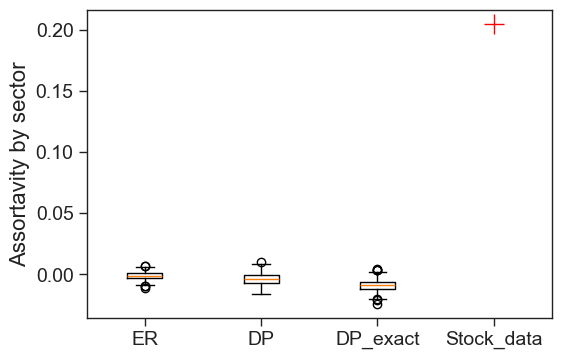

In [261]:
# assortavity
# DP exact means setting the exact same sector for the same node and not falling on probabilities
fig = plt.figure(figsize=(6,4))

plt.boxplot([assortativity_ER,assortativity_DP,assortativity_DP_exact], positions=[1,2,3])
plt.plot(4,assortativity_by_sector_real,'r',marker='+',markersize=15)
ax = plt.gca()
ax.set_xticks([1,2,3,4],labels=['ER','DP','DP_exact','Stock_data'])
plt.ylabel('Assortavity by sector')
plt.xlim([0.5,4.5])
plt.show()

In [262]:
deg_centrality_csv_path = "deg_centrality_df.csv"
cluster_csv_path = "cluster_df.csv"
eigen_csv_path = 'eigen_centrality_df.csv'

deg_centrality_df.to_csv(deg_centrality_csv_path)
cluster_df.to_csv(cluster_csv_path)
eigen_centrality_df.to_csv(eigen_csv_path)

C:\Users\drana\AppData\Local\Temp\ipykernel_6944\25647234.py:27: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  nx.draw_networkx_nodes(G_stocks, pos, node_color=colors, cmap=plt.cm.get_cmap('tab20'), node_size=30)


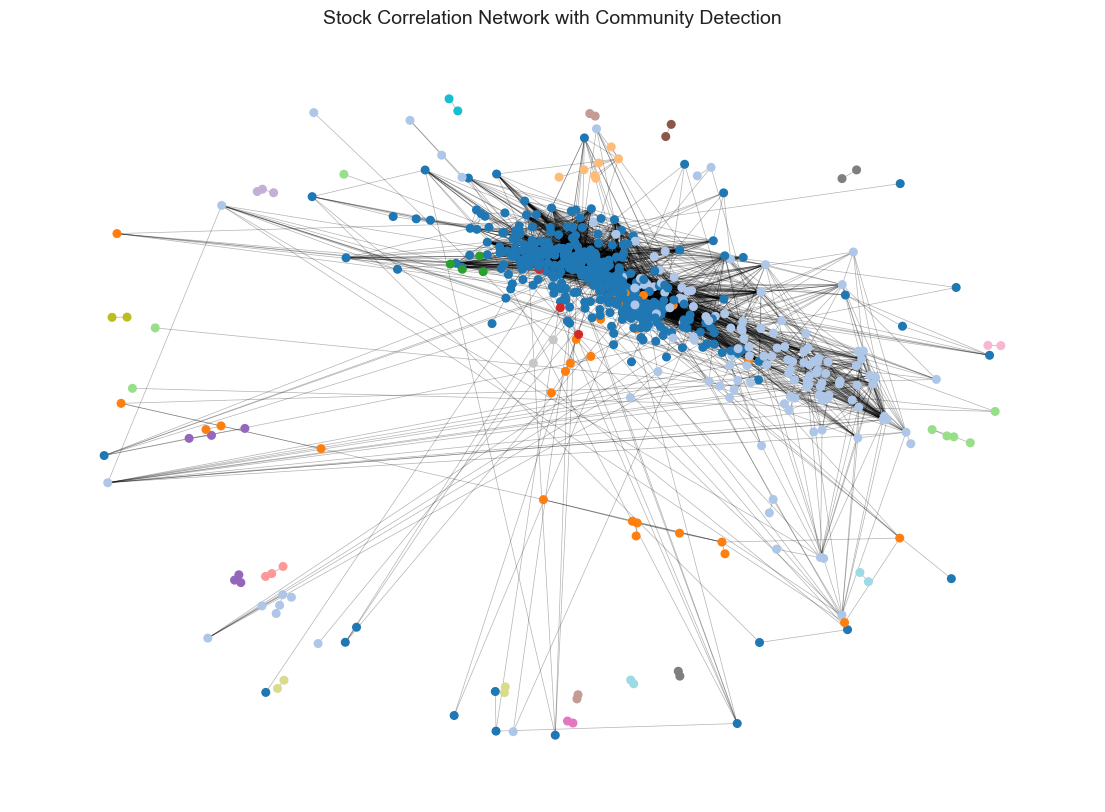

In [263]:
import matplotlib.pyplot as plt
import networkx.algorithms.community as nx_comm

# Apply the Louvain method for community detection (Blondel et al.)
from networkx.algorithms.community import greedy_modularity_communities

# Detect communities
communities = list(greedy_modularity_communities(G_stocks))

# Assign community ID to each node
community_map = {}
for i, community in enumerate(communities):
    for node in community:
        community_map[node] = i
        G_stocks.nodes[node]['community'] = i

# Draw the network with community separation
plt.figure(figsize=(14, 10))

# Create a layout that emphasizes community separation
pos = nx.spring_layout(G_stocks, seed=42)

# Assign color to each community
colors = [community_map[node] for node in G_stocks.nodes]

# Draw network
nx.draw_networkx_nodes(G_stocks, pos, node_color=colors, cmap=plt.cm.get_cmap('tab20'), node_size=30)
nx.draw_networkx_edges(G_stocks, pos, alpha=0.3, width=0.5)
plt.title("Stock Correlation Network with Community Detection", fontsize=14)
plt.axis("off")
plt.show()


In [264]:
from collections import Counter, defaultdict

# Step 1: Build mapping from community to list of sectors
community_sectors = defaultdict(list)

for node, data in G_stocks.nodes(data=True):
    sector = data.get('sector')
    community = data.get('community')
    if community is not None and sector is not None:
        community_sectors[community].append(sector)

# Step 2: Count sector occurrences within each community
community_sector_counts = {
    comm_id: dict(Counter(sectors)) for comm_id, sectors in community_sectors.items()
}

# Step 3: Create a summary DataFrame for comparison
community_sector_df = pd.DataFrame.from_dict(community_sector_counts, orient='index').fillna(0).astype(int)
community_sector_df.index.name = 'Community_ID'


community_sector_df


,Financial Services,Real Estate,Utilities,Consumer Defensive,Healthcare,NaN,Consumer Cyclical,Technology,Industrials,Energy,Information Technology,Basic Materials,Consumer Discretionary,Communication Services,Education,Materials
Community_ID,,,,,,,,,,,,,,,,
2,20,32,19,8,15,8,7,7,20,4,1,5,0,0,0,0
1,119,16,5,2,2,4,5,8,4,1,1,0,1,4,0,0
0,62,7,8,14,27,6,26,47,36,18,1,3,3,16,1,3
6,1,0,0,0,0,0,2,1,1,0,0,0,0,0,0,0
15,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
21,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
3,0,1,0,0,0,1,1,0,9,1,0,1,0,0,0,0
10,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,0,1,0,0,2,0,3,1,0,0,0,0,0,0,0,0


In [265]:
# STEP 3: Louvain detection function (as-is)
def detect_and_draw_louvain_communities(G, title="Louvain Community Detection"):
    partition = community_louvain.best_partition(G, weight='None')
    nx.set_node_attributes(G, partition, "community")
    pos = nx.spring_layout(G, seed=42)
    community_colors = [partition[node] for node in G.nodes]

    # plt.figure(figsize=(14, 10))
    # nx.draw_networkx_nodes(G, pos, node_color=community_colors, cmap=plt.cm.get_cmap('tab20'), node_size=30)
    # nx.draw_networkx_edges(G, pos, alpha=0.3, width=0.5)
    # plt.title(title, fontsize=14)
    # plt.axis("off")
    # plt.show()

    return partition

In [266]:
# STEP 4: Run 
louvain_partition_real = detect_and_draw_louvain_communities(G_stocks, title="Louvain on Degree-Preserving Graph")

In [267]:
from community import community_louvain # pip install python-louvian community
import matplotlib.pyplot as plt
louvain_partition_dp_list = []

for i in range(1000):

    # STEP 1: Create a degree-preserving graph from your real graph
    degree_seq = [d for _, d in G_stocks.degree()]  # Use real degrees, not centrality
    G_dp = nx.configuration_model(degree_seq, seed=42)

    # Convert to simple graph (removes multiedges and self-loops)
    G_dp = nx.Graph(G_dp)
    G_dp.remove_edges_from(nx.selfloop_edges(G_dp))

    # STEP 2: Relabel nodes to match original tickers
    tickers = list(G_stocks.nodes)
    mapping = dict(zip(G_dp.nodes, tickers))
    G_dp = nx.relabel_nodes(G_dp, mapping)

    # Optional: Copy sectors from original graph
    sector_map = nx.get_node_attributes(G_stocks, 'sector')
    nx.set_node_attributes(G_dp, sector_map, 'sector')


    # STEP 4: Run 
    louvain_partition_dp = detect_and_draw_louvain_communities(G_dp, title="Louvain on Degree-Preserving Graph")
    louvain_partition_dp_list.append(louvain_partition_dp)

def most_common_per_key(dict_list):
    result = {}
    keys = dict_list[0].keys()  # assumes all dicts have the same keys
    for key in keys:
        values = [d[key] for d in dict_list if key in d]
        if values:
            result[key] = Counter(values).most_common(1)[0][0]
        else:
            result[key] = None
    return result

louvain_partition_dp_final = most_common_per_key(louvain_partition_dp_list)
louvain_partition_dp_final

{'BRK-B': 0,
 'PGR': 1,
 'WELL': 2,
 'WEC': 3,
 'BRO': 3,
 'PPL': 4,
 'ATO': 5,
 'LNT': 5,
 'EVRG': 5,
 'ORI': 5,
 'TOWN': 6,
 'WMT': 1,
 'JPM': 4,
 'COST': 7,
 'NFLX': 2,
 'TMUS': 4,
 'AXP': 0,
 'ISRG': 2,
 'T': 6,
 'GS': 5,
 'BSX': 2,
 'WMB': 2,
 'SPG': 2,
 'RCL': 2,
 'HLT': 0,
 'BK': 2,
 'KMI': 0,
 'HWM': 4,
 'MPLX': 2,
 'NDAQ': 0,
 'TRGP': 1,
 'GLW': 1,
 'ETR': 3,
 'STT': 5,
 'BR': 2,
 'AEE': 1,
 'CVNA': 0,
 'GDDY': 4,
 'FOX': 4,
 'FWONK': 0,
 'UI': 0,
 'NTRA': 7,
 'NI': 3,
 'PODD': 7,
 'USFD': 5,
 'CHWY': 5,
 'SFM': 3,
 'PRMB': 2,
 'TKO': 0,
 'DTM': 2,
 'TLN': 0,
 'EXLS': 5,
 'PLNT': 5,
 'WAY': 5,
 'EAT': 3,
 'FSK': 5,
 'CORT': 2,
 'PJT': 1,
 'GPI': 5,
 'VIRT': 6,
 'IDCC': 7,
 'TXNM': 0,
 'TGTX': 5,
 'AHR': 3,
 'CNO': 3,
 'TDS': 3,
 'GBTG': 5,
 'KNTK': 6,
 'FTDR': 4,
 'CARG': 4,
 'AVPT': 5,
 'HTLF': 2,
 'ENVA': 5,
 'GCMG': 1,
 'RSI': 6,
 'KYN': 3,
 'SYBT': 5,
 'CET': 0,
 'TPB': 5,
 'BBSI': 5,
 'CURLF': 4,
 'CBL': 1,
 'PRTH': 6,
 'NBN': 1,
 'MS': 3,
 'C': 1,
 'IBKR': 2,
 'EPD': 8,


In [277]:
# Extract unique sectors
sectors = set()
for node, data in G_stocks.nodes(data=True):
    sector = data.get("sector")
    if sector is not None:
        sectors.add(sector)

unique_sectors

array(['Financials', 'Consumer Defensive', 'Financial Services',
       'Technology', 'Communication Services', 'Healthcare',
       'Industrials', 'Consumer Cyclical', 'Utilities', 'Real Estate',
       'Energy', 'Basic Materials', 'Consumer Discretionary',
       'Health Care', 'Materials', 'Information Technology', 'Education'],
      dtype=object)

In [278]:
sector_color_map = {
    #  Small to medium banks
    'Financials': '#006400',             # Dark Green
    'Financial Services': '#228B22',     # Forest Green

    #  Insurance / Investment Firms
    'Healthcare': '#FF69B4',             # Hot Pink
    'Health Care': '#FFB6C1',            # Light Pink

    #  Property related
    'Real Estate': '#1E90FF',            # Dodger Blue

    #  Overlapping + Energy
    'Energy': '#32CD32',                 # Lime Green

    #  Wildcards and Others
    'Consumer Defensive': '#FFA500',     # Orange
    'Consumer Cyclical': '#FF8C00',      # Dark Orange
    'Consumer Discretionary': '#FFD700', # Gold
    'Technology': '#FF7F50',             # Coral
    'Communication Services': '#FF4500', # OrangeRed
    'Industrials': '#FFA07A',            # Light Salmon
    'Utilities': '#F4A460',              # Sandy Brown
    'Basic Materials': '#D2691E',        # Chocolate
    'Materials': '#CD853F',              # Peru
    'Information Technology': '#FFA07A', # Light Salmon (grouped with tech)
    'Education': '#FFE4B5'               # Moccasin
}

C:\Users\drana\AppData\Local\Temp\ipykernel_6944\3535560651.py:35: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  nx.draw_networkx_nodes(G_stocks, positions, node_color=colors, cmap=plt.cm.get_cmap('tab20'), node_size=30)


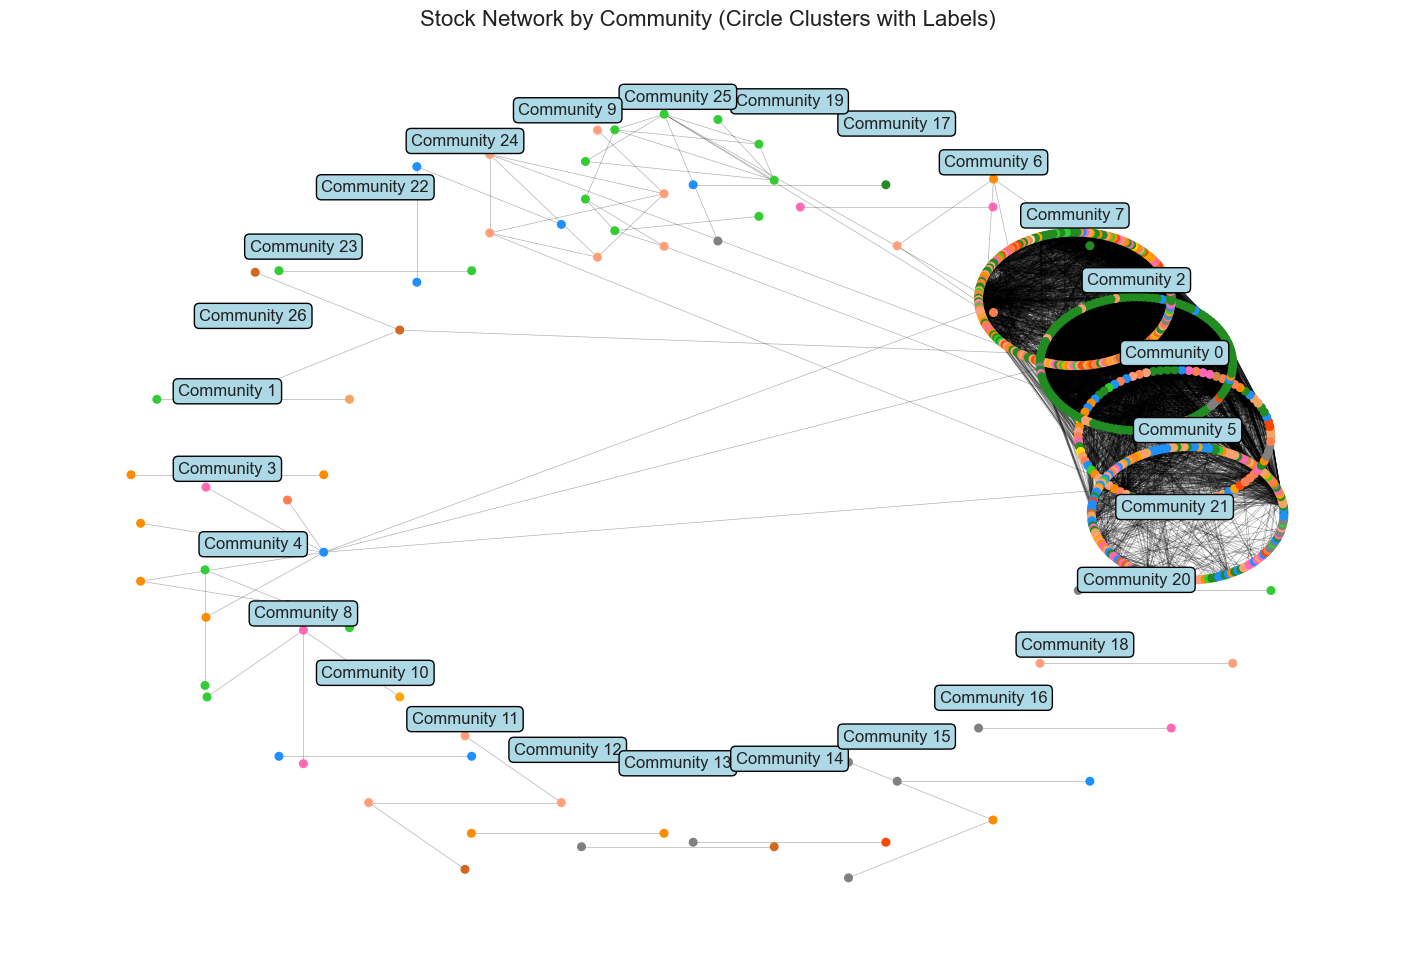

In [280]:
# Step 1: Group nodes by community
community_groups = {}
for node, community_id in louvain_partition_real.items():
    community_groups.setdefault(community_id, []).append(node)

# Step 2: Create positions — circle layout per community
positions = {}
radius = 2
angle_step = 2 * np.pi / len(community_groups)
community_centers = {}

for i, (comm_id, nodes) in enumerate(community_groups.items()):
    # Place each community center in a large circle
    angle = i * angle_step
    center_x = 10 * np.cos(angle)
    center_y = 10 * np.sin(angle)
    community_centers[comm_id] = (center_x, center_y)

    # Place nodes in a mini circle around the community center
    node_angles = np.linspace(0, 2 * np.pi, len(nodes), endpoint=False)
    for j, node in enumerate(nodes):
        x = center_x + radius * np.cos(node_angles[j])
        y = center_y + radius * np.sin(node_angles[j])
        positions[node] = (x, y)

# Step 3: Assign colors based on sectors
colors = []
for node in louvain_partition_real:  # use nodes from partition
    sector = G_stocks.nodes[node].get("sector", "Unknown")
    color = sector_color_map.get(sector, "gray")  # fallback to gray
    colors.append(color)

# Step 4: Draw graph
plt.figure(figsize=(18, 12))
nx.draw_networkx_nodes(G_stocks, positions, node_color=colors, cmap=plt.cm.get_cmap('tab20'), node_size=30)
nx.draw_networkx_edges(G_stocks, positions, alpha=0.3, width=0.5)

# Step 5: Add labels above each community
for comm_id, (x, y) in community_centers.items():
    plt.text(x, y + 2.5, f"Community {comm_id}", fontsize=12, ha='center', va='center', 
             bbox=dict(boxstyle="round,pad=0.3", fc="lightblue", ec="black", lw=1))

plt.title("Stock Network by Community (Circle Clusters with Labels)", fontsize=16)
plt.axis("off")
plt.show()

community 25 - energy sector

C:\Users\drana\AppData\Local\Temp\ipykernel_6944\1363524538.py:35: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  nx.draw_networkx_nodes(G_stocks, positions, node_color=colors, cmap=plt.cm.get_cmap('tab20'), node_size=30)


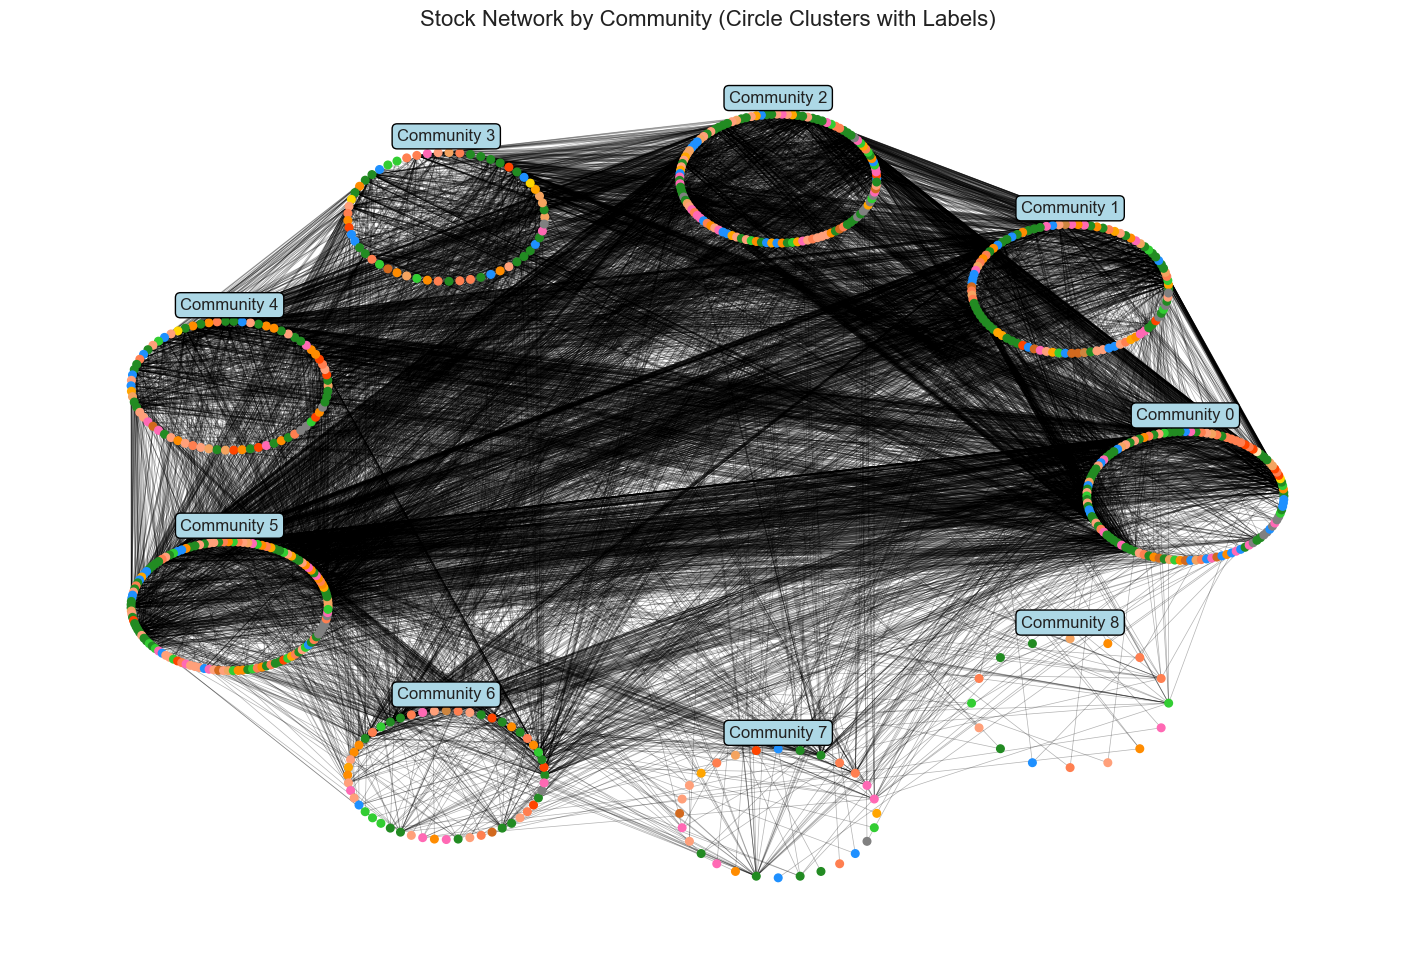

In [281]:
# Step 1: Group nodes by community
community_groups = {}
for node, community_id in louvain_partition_dp_final.items():
    community_groups.setdefault(community_id, []).append(node)

# Step 2: Create positions — circle layout per community
positions = {}
radius = 2
angle_step = 2 * np.pi / len(community_groups)
community_centers = {}

for i, (comm_id, nodes) in enumerate(community_groups.items()):
    # Place each community center in a large circle
    angle = i * angle_step
    center_x = 10 * np.cos(angle)
    center_y = 10 * np.sin(angle)
    community_centers[comm_id] = (center_x, center_y)

    # Place nodes in a mini circle around the community center
    node_angles = np.linspace(0, 2 * np.pi, len(nodes), endpoint=False)
    for j, node in enumerate(nodes):
        x = center_x + radius * np.cos(node_angles[j])
        y = center_y + radius * np.sin(node_angles[j])
        positions[node] = (x, y)

# Step 3: Assign colors based on sectors
colors = []
for node in louvain_partition_real:  # use nodes from partition
    sector = G_stocks.nodes[node].get("sector", "Unknown")
    color = sector_color_map.get(sector, "gray")  # fallback to gray
    colors.append(color)

# Step 4: Draw graph
plt.figure(figsize=(18, 12))
nx.draw_networkx_nodes(G_stocks, positions, node_color=colors, cmap=plt.cm.get_cmap('tab20'), node_size=30)
nx.draw_networkx_edges(G_stocks, positions, alpha=0.3, width=0.5)

# Step 5: Add labels above each community
for comm_id, (x, y) in community_centers.items():
    plt.text(x, y + 2.5, f"Community {comm_id}", fontsize=12, ha='center', va='center', 
             bbox=dict(boxstyle="round,pad=0.3", fc="lightblue", ec="black", lw=1))

plt.title("Stock Network by Community (Circle Clusters with Labels)", fontsize=16)
plt.axis("off")
plt.show()

In [282]:
from collections import Counter, defaultdict

# Step 1: Build mapping from community to list of sectors
community_sectors = defaultdict(list)

for node, data in G_stocks.nodes(data=True):
    sector = data.get('sector')
    community = data.get('community')
    if community is not None and sector is not None:
        community_sectors[community].append(sector)

# Step 2: Count sector occurrences within each community
community_sector_counts = {
    comm_id: dict(Counter(sectors)) for comm_id, sectors in community_sectors.items()
}

# Step 3: Create a summary DataFrame for comparison
community_sector_df = pd.DataFrame.from_dict(community_sector_counts, orient='index').fillna(0).astype(int)
community_sector_df.index.name = 'Community_ID'


community_sector_df

,Financial Services,Real Estate,Utilities,Consumer Defensive,Technology,Healthcare,NaN,Consumer Cyclical,Energy,Industrials,Materials,Information Technology,Communication Services,Basic Materials,Consumer Discretionary,Education
Community_ID,,,,,,,,,,,,,,,,
5,24,40,18,8,8,19,9,8,6,22,1,2,2,5,0,0
0,13,10,7,2,15,7,3,9,2,9,1,0,3,1,2,0
2,113,3,2,0,1,1,4,2,0,3,0,0,1,0,0,0
7,52,3,5,14,39,18,4,23,17,30,1,1,14,3,2,1
6,1,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0
19,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
24,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,1,0,0,1,2,0,3,0,0,0,0,0,0,0,0
10,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Luvian community detection - for report (calculate the communities) attributes (modularity is the main one) modularity score (Metric)
eigen vlaue coeffient (also used for null values) - how one node effects other nodes
Matrix - only for assortivity (need a matrix) (the visualisation)
Pearsonn coefficient - for edges
rich clubs - do the calculation (might be the assortivity i am using) total connections/ max possible connections (might be based on weights so not needed)

In [283]:
# Create a dictionary where each community ID maps to a list of (ticker, sector) tuples
community_sector_info = {}

for node, community_id in louvain_partition_real.items():
    sector = G_stocks.nodes[node].get("sector", "Unknown")
    if community_id not in community_sector_info:
        community_sector_info[community_id] = []
    community_sector_info[community_id].append((node, sector))

community_sector_info


{5: [('BRK-B', 'Financial Services'),
  ('PGR', 'Financial Services'),
  ('WELL', 'Real Estate'),
  ('BRO', 'Financial Services'),
  ('PPL', 'Utilities'),
  ('LNT', 'Utilities'),
  ('EVRG', 'Utilities'),
  ('ORI', 'Financial Services'),
  ('COST', 'Consumer Defensive'),
  ('GLW', 'Technology'),
  ('WAY', 'Healthcare'),
  ('VIRT', 'Financial Services'),
  ('HTLF', nan),
  ('TJX', 'Consumer Cyclical'),
  ('ORCL', 'Technology'),
  ('MSI', 'Technology'),
  ('ARLP', 'Energy'),
  ('PM', 'Consumer Defensive'),
  ('GEV', 'Utilities'),
  ('OGE', 'Utilities'),
  ('ESE', 'Industrials'),
  ('AJG', 'Financial Services'),
  ('DGX', 'Healthcare'),
  ('LTH', 'Consumer Cyclical'),
  ('PBI', 'Industrials'),
  ('CRS', 'Materials'),
  ('MMSI', 'Healthcare'),
  ('GMED', 'Healthcare'),
  ('COOP', 'Financial Services'),
  ('MWA', 'Industrials'),
  ('RTX', 'Industrials'),
  ('DUK', 'Utilities'),
  ('MMM', 'Industrials'),
  ('SN', 'Consumer Cyclical'),
  ('BKV', 'Energy'),
  ('SPGI', 'Financial Services'),
  (

In [271]:
import collections

jdd_counter = collections.Counter()

def compute_joint_degree_distribution(G_stocks):
    for u, v in G_stocks.edges():
        deg_u = G_stocks.degree[u]
        deg_v = G_stocks.degree[v]
        # Sort to keep symmetry
        k1, k2 = sorted((deg_u, deg_v))
        jdd_counter[(k1, k2)] += 1

    # Convert to matrix form
    max_deg = max(max(k1, k2) for k1, k2 in jdd_counter.keys())
    jdd_matrix = np.zeros((max_deg + 1, max_deg + 1))

    for (k1, k2), count in jdd_counter.items():
        jdd_matrix[k1][k2] = count
        if k1 != k2:
            jdd_matrix[k2][k1] = count  # Symmetric

    # Normalize to get probabilities
    avg_degree = sum(dict(G_stocks.degree()).values()) / G_stocks.number_of_nodes()
    jdd_matrix /= avg_degree
    return jdd_matrix

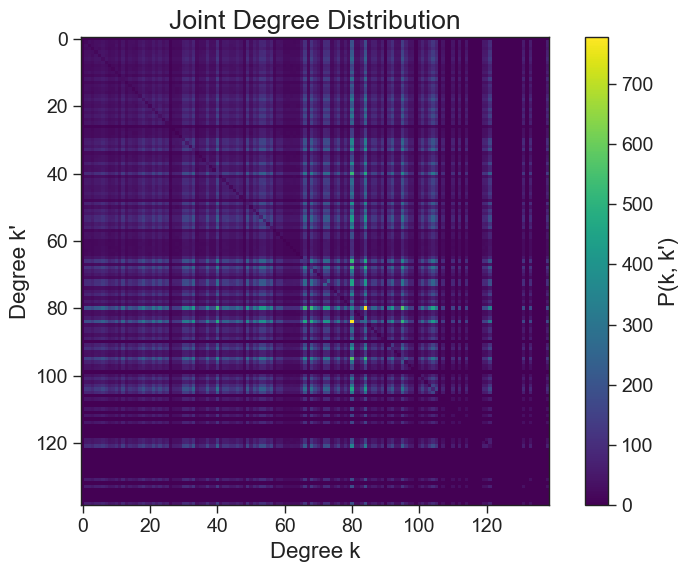

In [301]:
def plot_joint_degree_distribution(jdd_matrix, title='Joint Degree Distribution'):
    plt.figure(figsize=(8, 6))
    plt.imshow(jdd_matrix, origin='upper', cmap='viridis')
    plt.colorbar(label="P(k, k')")
    plt.xlabel('Degree k')
    plt.ylabel("Degree k'")
    plt.title(title)
    plt.tight_layout()
    plt.show()

jdd_matrix = compute_joint_degree_distribution(G_stocks)
plot_joint_degree_distribution(jdd_matrix)



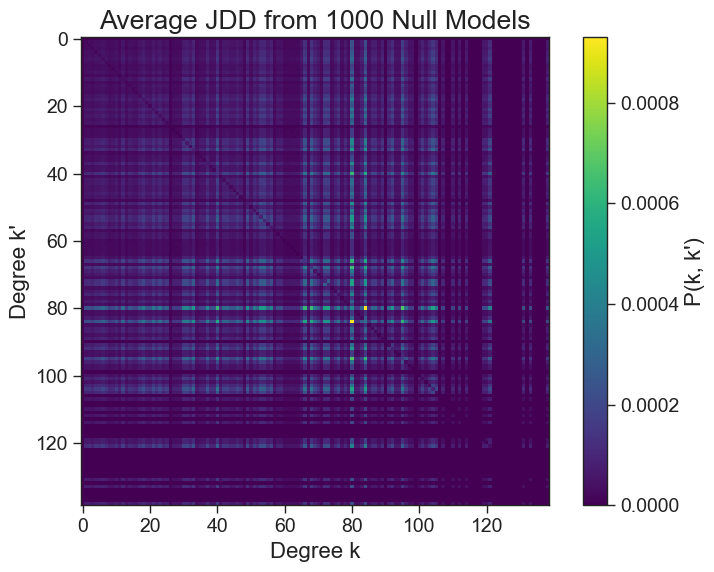

In [294]:
def compute_average_jdd_from_null_models(G_original, num_models=1000):
    max_deg = max(dict(G_original.degree()).values())
    cumulative_matrix = np.zeros((max_deg + 1, max_deg + 1))

    for i in range(num_models):
        G_random = G_original.copy()
        nx.double_edge_swap(G_random, nswap=10 * G_random.number_of_edges(), max_tries=1000000)
        jdd_matrix = compute_joint_degree_distribution(G_random)

        # Pad matrix if smaller due to lower max degree
        current_shape = jdd_matrix.shape[0]
        if current_shape < cumulative_matrix.shape[0]:
            padded = np.zeros_like(cumulative_matrix)
            padded[:current_shape, :current_shape] = jdd_matrix
            jdd_matrix = padded

        cumulative_matrix += jdd_matrix

    average_jdd = cumulative_matrix / num_models
    average_jdd /= np.sum(average_jdd)
    return average_jdd

avg_jdd_null = compute_average_jdd_from_null_models(G_stocks, num_models=1000)
plot_joint_degree_distribution(avg_jdd_null, title='Average JDD from 1000 Null Models')

In [287]:
for node in G_stocks.nodes:
    # Add degree centrality attribute if available
    if node in degree_centrality_real:
        G_stocks.nodes[node]['degree_centrality'] = degree_centrality_real[node]
    
    # Add eigenvector centrality attribute if available
    if node in eigen_centrality_real:
        G_stocks.nodes[node]['eigenvector_centrality'] = eigen_centrality_real[node]
    
    # Add clustering coefficient attribute if available
    if node in cluster_coefficent_stock_real:
        G_stocks.nodes[node]['clustering_coefficient'] = cluster_coefficent_stock_real[node]
# Step 4: Export to GEXF, export grpah to gephi for better visualization
nx.write_gexf(G_stocks, "stock_network_communities.gexf")

In [290]:
from collections import defaultdict
import pandas as pd

sector_external_degree = defaultdict(int)
sector_node_counts = defaultdict(int)

# Loop through all nodes to compute external degree
for node in G_stocks.nodes():
    node_sector = G_stocks.nodes[node].get("sector")
    if node_sector is None:
        continue

    sector_node_counts[node_sector] += 1  # Count nodes in each sector

    for neighbor in G_stocks.neighbors(node):
        neighbor_sector = G_stocks.nodes[neighbor].get("sector")
        if neighbor_sector != node_sector:
            sector_external_degree[node_sector] += 1

# Compute average external degree
average_external_degree = {
    sector: sector_external_degree[sector] / sector_node_counts[sector]
    for sector in sector_external_degree
}

# Create DataFrame
external_degree_df = pd.DataFrame({
    'Total External Degree': sector_external_degree,
    'Average External Degree': average_external_degree
})
external_degree_df.index.name = 'Sector'

# Display the DataFrame
external_degree_df.to_csv('external_degree_df.csv')
external_degree_df

,Total External Degree,Average External Degree
Sector,,
Financial Services,2721,13.338235
Real Estate,714,11.156250
Utilities,749,22.696970
Consumer Defensive,478,19.120000
Communication Services,329,15.666667
Healthcare,524,10.076923
Energy,715,17.023810
Consumer Cyclical,624,12.235294
Industrials,1038,14.027027


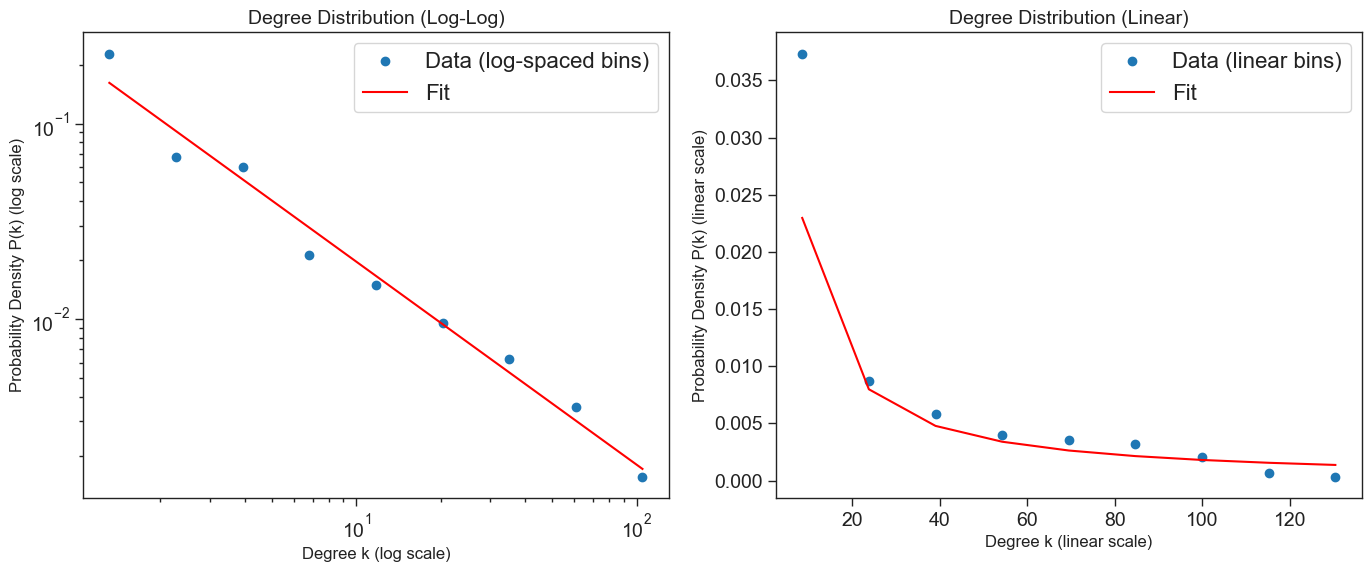

Fitted power-law parameters:
  Slope (exponent): -1.038
  Intercept: -0.669


In [298]:
# import numpy as np
# import matplotlib.pyplot as plt
# import networkx as nx

# --- Assume you already have your graph G ---
# Example:
# G = nx.read_edgelist("your_edge_list.txt", nodetype=str)
# degrees = np.array([G.degree(node) for node in G])
# kmin = min(degrees)
# kmax = max(degrees)

# For demonstration, let's create a sample graph (remove or replace this block with your data)
G = G_stocks
degrees = np.array([G.degree(node) for node in G])
kmin = max(1, min(degrees))  # ensure kmin>=1 for log calculations
kmax = max(degrees)

# ---- Histogram using logarithmically spaced bins for log-log plot ----
num_bins = 10
bin_edges_log = np.logspace(np.log10(kmin), np.log10(kmax), num=num_bins)
density_log, _ = np.histogram(degrees, bins=bin_edges_log, density=True)
# Calculate midpoints in log space:
midpoints_log = 10 ** ((np.log10(bin_edges_log[:-1]) + np.log10(bin_edges_log[1:])) / 2)

# Perform linear regression in log-log space
log_midpoints_log = np.log10(midpoints_log)
log_density_log = np.log10(density_log)
slope, intercept = np.polyfit(log_midpoints_log, log_density_log, 1)
fitted_log_density = 10 ** (slope * log_midpoints_log + intercept)

# ---- Histogram using linearly spaced bins for linear plot ----
bin_edges_linear = np.linspace(kmin, kmax, num=num_bins)
density_linear, _ = np.histogram(degrees, bins=bin_edges_linear, density=True)
midpoints_linear = (bin_edges_linear[:-1] + bin_edges_linear[1:]) / 2
# Use the same fitted model (power-law) for the linear-scale plot:
fitted_density_linear = 10 ** (slope * np.log10(midpoints_linear) + intercept)

# ---- Create plots side by side ----
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# Log-Log plot:
axs[0].loglog(midpoints_log, density_log, marker='o', linestyle='none', label='Data (log-spaced bins)')
axs[0].loglog(midpoints_log, fitted_log_density, linestyle='-', color='red',
             label=f'Fit')
# axs[0].loglog(midpoints_log, fitted_log_density, linestyle='-', color='red',
#              label=f'Fit: slope = {slope:.2f}')
axs[0].set_xlabel('Degree k (log scale)', fontsize=12)
axs[0].set_ylabel('Probability Density P(k) (log scale)', fontsize=12)
axs[0].set_title('Degree Distribution (Log-Log)', fontsize=14)
axs[0].legend()

# Linear plot:
axs[1].plot(midpoints_linear, density_linear, marker='o', linestyle='none', label='Data (linear bins)')
axs[1].plot(midpoints_linear, fitted_density_linear, linestyle='-', color='red',
            label=f'Fit')
# axs[1].plot(midpoints_linear, fitted_density_linear, linestyle='-', color='red',
#             label=f'Fit: slope = {slope:.2f}')
axs[1].set_xlabel('Degree k (linear scale)', fontsize=12)
axs[1].set_ylabel('Probability Density P(k) (linear scale)', fontsize=12)
axs[1].set_title('Degree Distribution (Linear)', fontsize=14)
axs[1].legend()

plt.tight_layout()
plt.show()

# Print fitted parameters for reference
print("Fitted power-law parameters:")
print(f"  Slope (exponent): {slope:.3f}")
print(f"  Intercept: {intercept:.3f}")


In [ ]:
def intercluster_edge_matrix(G, cluster_map):
    """
    Compute a matrix showing the number of edges between each pair of clusters.

    Parameters:
    - G: networkx.Graph
    - cluster_map: dict mapping node to cluster ID

    Returns:
    - pandas.DataFrame: symmetric matrix of edge counts between cluster pairs
    """
    clusters = sorted(set(cluster_map.values()))
    matrix = pd.DataFrame(0, index=clusters, columns=clusters)

    for u, v in G.edges():
        clu_u = cluster_map.get(u)
        clu_v = cluster_map.get(v)
        if clu_u is not None and clu_v is not None:
            matrix.loc[clu_u, clu_v] += 1
            if clu_u != clu_v:
                matrix.loc[clu_v, clu_u] += 1  # Ensure symmetry for undirected graph

    return matrix

# Generate inter-cluster edge matrix
intercluster_matrix = intercluster_edge_matrix(G_stocks, louvain_partition_real)

# Display matrix
print(intercluster_matrix)

     0     1     2    3   4   5   6   7   8   9   ...  17  18  19  20  21  22  \
0   875   399   476    0   0   0   1   1   0   0  ...   0   0   0   0   0   0   
1   399  2694   944  194   0   0   2   1   0   0  ...   0   0   0   1   0   0   
2   476   944  2740    7   0   0   0   0   0   0  ...   0   0   0   0   0   0   
3     0   194     7  243   0   0   0   0   0   0  ...   0   0   0   0   0   0   
4     0     0     0    0   1   0   0   0   0   0  ...   0   0   0   0   0   0   
5     0     0     0    0   0   1   0   0   0   0  ...   0   0   0   0   0   0   
6     1     2     0    0   0   0  15   0   0   0  ...   0   0   0   0   0   0   
7     1     1     0    0   0   0   0   7   0   0  ...   0   0   0   0   0   0   
8     0     0     0    0   0   0   0   0   2   0  ...   0   0   0   0   0   0   
9     0     0     0    0   0   0   0   0   0   1  ...   0   0   0   0   0   0   
10    0     0     0    0   0   0   0   0   0   0  ...   0   0   0   0   0   0   
11    0     1     0    0   0